<a href="https://colab.research.google.com/github/aryamanpathak2022/Approximate-Recursive-Multipliers/blob/main/Q2/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import imutils
import cv2
import os
from tqdm import tqdm
import argparse

In [105]:
# input from user
input_dir = input("Enter the input directory: ")
output_dir = input("Enter the output directory: ")

Enter the input directory: ./
Enter the output directory: ./


In [110]:
# Load images and filter out non-numeric filenames
img_path = [os.path.join(input_dir, i) for i in os.listdir(input_dir) if os.path.splitext(i)[0].isdigit()]
assert len(img_path) > 0, "No valid images found in input folder"

# Sort by numeric filename
img_path.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

In [111]:
# Read the first image
left_img = cv2.imread(img_path[0])
left_img = imutils.resize(left_img, width=600)
# cv2_imshow(left_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [112]:
from google.colab.patches import cv2_imshow

2


  0%|          | 0/1 [00:00<?, ?it/s]

Keypoints in Left Image: 1966, Right Image: 1692
Using 637 matches to compute homography
Homography Matrix:
 [[ 5.73313169e-01  1.47812286e-02  1.85217298e+02]
 [-1.76426115e-01  8.35804536e-01  4.40075932e+01]
 [-7.06797512e-04 -1.03880420e-05  1.00000000e+00]]


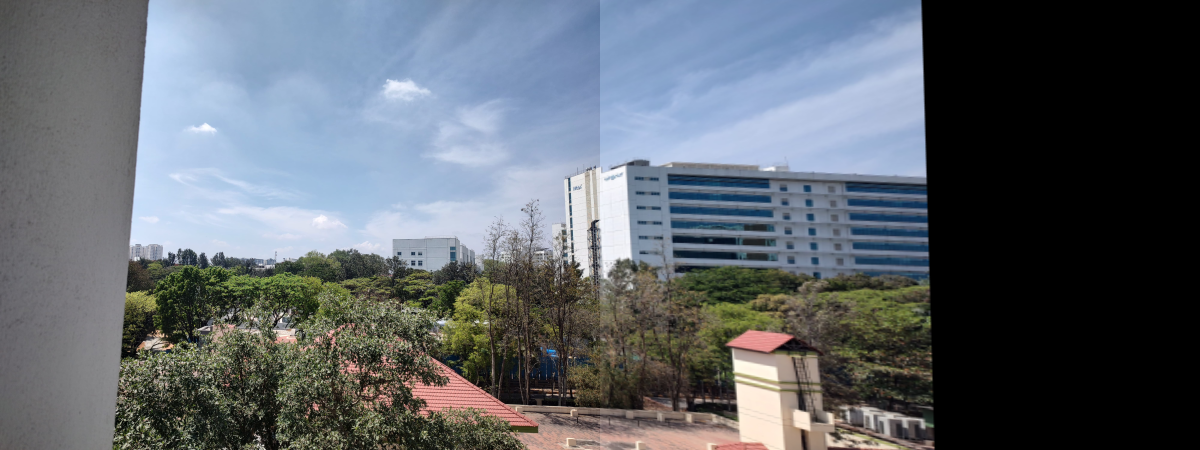

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


In [113]:
#process
# Iterate through images
print(len(img_path))
for i in tqdm(range(1, len(img_path))):
    right_img = cv2.imread(img_path[i])
    right_img = imutils.resize(right_img, width=600)


    # Swap left and right images to maintain correct stitching order
    temp_img=right_img
    right_img=left_img
    left_img=temp_img
    # Detect keypoints and descriptors using SIFT
    descriptor = cv2.SIFT_create()
    kpsA, desA = descriptor.detectAndCompute(left_img, None)

    kpsB, desB = descriptor.detectAndCompute(right_img, None)
    kpsA=np.float32([kp.pt for kp in kpsA]) #keypoints to float32 array
    kpsB=np.float32([kp.pt for kp in kpsB]) #keypoints to float32 array
    print(f"Keypoints in Left Image: {len(kpsA)}, Right Image: {len(kpsB)}")

    # Match keypoints using KNN
    matcher = cv2.BFMatcher()
    rawMatches = matcher.knnMatch(desA, desB, k=2)

    matches = []
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    if len(matches) > 4:
        print(f"Using {len(matches)} matches to compute homography")
        # Extract (x, y) coordinates from keypoints
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])

        # Compute homography
        H, status = cv2.findHomography(ptsA,ptsB, cv2.RANSAC, 5.0)

        if H is None:
          print("Homography matrix is None! Not enough matches?")
          continue

        print("Homography Matrix:\n", H)
        # Warp left image to new perspective
        new_width = left_img.shape[1] + right_img.shape[1]
        new_height = max(left_img.shape[0], right_img.shape[0])
        pano_img = cv2.warpPerspective(left_img, H, (new_width, new_height))


        # Compute the minimum height and width to avoid size mismatch
        min_height = min(pano_img.shape[0], right_img.shape[0])
        min_width = min(pano_img.shape[1], right_img.shape[1])

        # Crop  image to the same size
        pano_img[0:right_img.shape[0], 0:right_img.shape[1]] = right_img

        cv2_imshow(pano_img)
        # Convert to grayscale and crop black regions
        gray = cv2.cvtColor(pano_img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            x, y, w, h = cv2.boundingRect(contours[0])
            pano_img = pano_img[y:y+h-1, x:x+w-1]  # Crop non-black region

        left_img = pano_img.copy()  # Update left_img for next iteration



In [114]:
cv2.imwrite(os.path.join(output_dir, "panorama.jpg"), left_img) # save the panoroma to output dir

True